Данные <a href='https://mega.nz/folder/2ToAVa7Y#ZxnFgMjMVMyo07LC1W0IaQ'>Отсюда</a>, (какая у них может быть лицензия не представляю)
+ период 2006 - 2020, 
+ всего - 228511 записей,
+ медианная длин поля контент ~5400 символов

+ всего записей после фильтрации - 200566
+ медианная длина поля контент ~6477.5 символов
<br><br>
  + Удадены статьи не на русском языке ~1005
  + Статьи с пустым полем контент ~150
  + Все статьи длиной меньше 1050 знаков (что примерно ~150 слов)
  + Все записи без тегов
<br><br>
+ В итоге : классифицируем 50590 записей на 120 классов, отфильтрованных по популярным тэгам
<br><br>
Для тегирования может быть лучше произвести кластеризацию текстов
<br><br>
У статей на хабре ещё есть score и reading_count. Их тоже можно предсказывать.

In [1]:
import os
import gc
gc.enable()

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter


import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import joblib

from tensorflow import keras
layers = keras.layers
models = keras.models


In [2]:
tqdm.pandas()
gc.collect()

C:\Users\Paul\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


62

Reading all data

In [3]:
conn = sqlite3.connect("habr_articles\\habr.db")
cur = conn.cursor()
sql = "SELECT * FROM habr"
df = pd.read_sql(sql, conn)
cur.close()
conn.close()


gc.collect()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228512 entries, 0 to 228511
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              228512 non-null  int64 
 1   time_published  228512 non-null  object
 2   author          228512 non-null  object
 3   title           228512 non-null  object
 4   content         228512 non-null  object
 5   lang            228512 non-null  object
 6   comments_count  228512 non-null  int64 
 7   reading_count   228512 non-null  int64 
 8   score           228512 non-null  int64 
 9   is_tutorial     228512 non-null  int64 
 10  tags_string     228512 non-null  object
dtypes: int64(5), object(6)
memory usage: 19.2+ MB


In [4]:
df.tail()

,id,time_published,author,title,content,lang,comments_count,reading_count,score,is_tutorial,tags_string
228507,490394,2020-02-28T16:57:33+03:00,it_man,Commodore Amiga 500+: пусть никто не уйдет оби...,Сердца всех «компьютерщиков» постсоветского пр...,ru,4,2604,9,0,"amiga, amiga 500, amiga 500 plus, commodore, t..."
228508,490398,2020-02-28T18:34:14+03:00,vad_nes,"Красный Хогвартс. Офицеры, или Почему историк ...",<i>(Мы продолжаем цикл очерков из истории наше...,ru,8,3720,20,0,"ниту мисис, нестеров, мга, люди мга, красный х..."
228509,490400,2020-02-28T16:43:20+03:00,andrej007,Использование библиотеки OpenCV для распознава...,<p>В связи с все более широким распространение...,ru,0,680,5,1,"OpenCV, облака точек, обработка изображений, э..."
228510,490404,2020-02-28T17:05:49+03:00,SIMCom_RUS,"Почему и как 5G изменит все: технологии, поэта...","<img src=""https://habrastorage.org/webt/zi/7n/...",ru,12,5243,6,0,"5G, Интернет вещей, SIM8200G, SIM8200EA-M2, SI..."
228511,490406,2020-02-28T17:48:41+03:00,Trend_Micro,Невыразимо привлекателен: как мы создали ханип...,"<img src=""https://habrastorage.org/webt/qi/wa/...",ru,9,7505,28,0,"trend micro, ханипот, honeypot, исследование, ..."


In [5]:
df['time_published'] = pd.to_datetime(df.time_published)

In [6]:
df['time_published'].max(),df['time_published'].min()

(datetime.datetime(2020, 3, 1, 10, 49, 59, tzinfo=tzoffset(None, 10800)),
 datetime.datetime(2006, 1, 16, 21, 2, 59, tzinfo=tzoffset(None, 10800)))

In [7]:
df.lang.value_counts()

ru    227507
en      1005
Name: lang, dtype: int64

In [8]:
df = df[df.lang=='ru']

In [9]:
df  = df.drop(['lang','author','time_published','is_tutorial'],axis=1)

Text(0.5, 1.0, 'логарифм длины поля контент в символах')

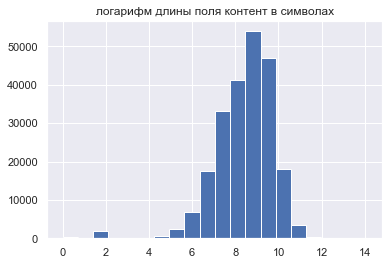

In [10]:
ss = df.content.apply(lambda s: len(s))
df['len'] = df.content.apply(lambda s: len(s))
plt.hist(np.log1p(ss),bins=20);
plt.title('логарифм длины поля контент в символах')

In [11]:
print(f'Медианная длина поля контент {np.median(ss)}')

Медианная длина поля контент 5399.0


In [12]:
#присутствуют пустые записи или записи из ~7 слов
Counter(ss).most_common(10)

[(6, 1960),
 (0, 150),
 (137, 110),
 (1, 75),
 (158, 61),
 (1022, 52),
 (1031, 46),
 (1034, 46),
 (965, 46),
 (1793, 45)]

In [13]:
#Возьмем минимум слов 150 что ~ 1050 символов
MS = 1050
df = df[df.len>=MS]

Text(0.5, 1.0, 'логарифм длины поля контент в символах')

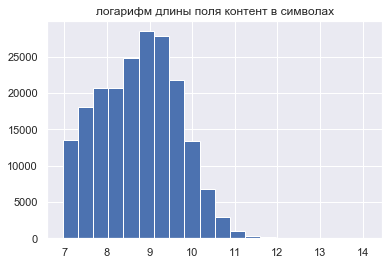

In [14]:
plt.hist(np.log1p(df.len),bins=20);
plt.title('логарифм длины поля контент в символах')

In [15]:
print(f'Медианная длина поля контент {np.median(df.len)}')
print(f'Минимальная длина поля контент {np.min(df.len)}')

Медианная длина поля контент 6477.5
Минимальная длина поля контент 1050


In [16]:
df['tags_string'].dropna(inplace=True)
df.shape

(200566, 8)

In [17]:
df.head()

,id,title,content,comments_count,reading_count,score,tags_string,len
21,27,Владислав Улендеев о трафике с Яндекс.Маркет,"Чтобы оживить группу, публикую ответ исполните...",41,3420,3,"электронная коммерция, Владислав Улендеев, эфф...",1146
24,30,Добавить в избранное.,Господа с бесконечной кармой. Хотелось бы узна...,2,1648,1,"избранное, статьи, favourities.",1362
29,36,Ответ на вопрос об очевидном,"Я знал и раньше, а теперь осознал, чем группы ...",3,444,0,"blog, группа, тред",1064
32,40,AdAge — статьи про Интернет-маркетинг (part 1),У меня в руках два наугад отобранных номера Ad...,2,781,0,"AdAge, реклама, branding, брендинг, PR, пресса...",3344
33,42,AdAge — статьи про Интернет-маркетинг (part 2),"Нет времени писать о каждой статье подробно, а...",0,654,0,"AdAge, реклама, branding, брендинг, PR, пресса...",1806


Работа стекстом

In [21]:
def remove_html_tags(t):
    '''
    removes html tags
    '''
    pattern = re.compile('<.*?>')
    return re.sub(pattern, '', t)

def memorize(function):
    '''
    wraper function for storing and 
    reusing previously obtained results
    '''
    memo = {}
    def wrapper(*args):
        if args in memo:#.keys(): same
            return memo[args]
        else:
            rv = function(*args)
            memo[args] = rv
        return rv
    return wrapper

@memorize
def parse_morph(w):
    '''
    return word in its initial form
    #lemmatization
    '''
    p = morph.parse(w)[0]
    normal_form = p.normal_form
    return normal_form

def prepare_text(t):
    '''
    prepares text for machine learning
    '''
    t = t.lower().strip()
    # filter all non letters symbols except for the space
    f = lambda l: l.isalpha() or l==' '
    t  = ''.join(filter(f, t))
    t = remove_html_tags(t)
    t = ' '.join([parse_morph(w) for w in t.split()]).strip()
    return t



In [22]:
#part1,part2,_,_ = train_test_split(df,df,test_size=0.5,shuffle=True)
#del df
gc.collect()

#part1['content'] = part1['content'].progress_apply(prepare_text)

#part2['content'] = part2['content'].progress_apply(prepare_text)

13464

In [21]:
#df = part1.append(part2)
df = part1
del part1
#del part2
df.head(2)

,id,title,content,comments_count,reading_count,score,tags_string,len
77534,129563,В Google Maps добавлен объемный «вертолетный р...,img srchttpshabrastorageorgstorageafeedaaadcef...,37,3154,69,"Google, сервисы, картографирование",2035
71606,120100,DEVCONF 2011 — 4 июня(суббота) &gt; 55 докладо...,коллега рад сообщить вы что a hrefhttpdevconfr...,26,4648,39,"devconf, php, perl, python, ruby, .net, javasc...",2692


In [23]:

gc.collect()

20

In [22]:
#df.to_csv('lower_and_lemma_habr_part1.csv',index=False)

Reading in all  the labels

In [27]:
T = []
for tags_list in df.tags_string.values:
    tags = [e.strip().lower()  for e in tags_list.split(',')]
    T.extend(tags)

choosing labels manually

In [3]:
'''
LABS = []
res = ''
while res!='e':
    for t in Counter(T).most_common():
        print(t)
        res = input()
        if res=='y':
            LABS.append(t[0].strip())
            print(LABS[-2:])
            print(len(LABS))
        if res=='n':
            pass
'''


"\nLABS = []\nres = ''\nwhile res!='e':\n    for t in Counter(T).most_common():\n        print(t)\n        res = input()\n        if res=='y':\n            LABS.append(t[0].strip())\n            print(LABS[-2:])\n            print(len(LABS))\n        if res=='n':\n            pass\n"

300

In [34]:
#joblib.dump(LABS,'labs.list')

['labs.list']

In [79]:
# check what's in the memory

In [115]:
df = pd.read_csv('lower_and_lemma_habr_part1.csv',usecols=['content','tags_string'])
LABS = joblib.load('labs.list')# надо лейблы пообъединять но это не сегодян

In [116]:
LABS = LABS[:100]

In [117]:
df = df.dropna()
df.head()

,content,tags_string
0,img srchttpshabrastorageorgstorageafeedaaadcef...,"Google, сервисы, картографирование"
1,коллега рад сообщить вы что a hrefhttpdevconfr...,"devconf, php, perl, python, ruby, .net, javasc..."
2,blockquoteemм продолжать публикация перевод по...,"Тестирование, производительность, performance,..."
3,на проходить февраль конференция a hrefhttppgc...,"tizen, sailfish, android, ios, минкомсвязи, ни..."
4,друг мы приглашать вы апрель на российский фин...,"imagine cup, конкурс программных проектов, сту..."


In [118]:
Y = pd.DataFrame()
for lab in LABS[:]:
    Y[lab] = df.tags_string.apply(lambda x: lab in x)
    

In [119]:
df = df[Y.sum(axis=1)>0]
Y =  Y[Y.sum(axis=1)>0]

df.shape

(50590, 2)

In [120]:
max_words = 65000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words,char_level=False)

In [121]:
tokenize.fit_on_texts(df['content']) 
joblib.dump(tokenize,'vectorizer.vect')

['vectorizer.vect']

In [122]:
P = 256
def generator(df,Y,tokenizer=tokenize,P=P):
    n_rows = df.shape[0]
    def init():
        return 0
    i = init()
    while True:
        vals = df['content'].values[i:i+P]
        ys = Y.values[i:i+P]
        i+=P
        yield tokenize.texts_to_matrix(vals),ys
        if i>=n_rows:
            i=init()

In [123]:
gen = generator(df,Y)
#next(gen)

In [124]:
n_words=max_words
n_classes = len(LABS)
def define_model(n_words=n_words,n_classes = n_classes):
    model = models.Sequential()
    model.add(layers.Dense(512, input_shape=(n_words,)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(n_classes))
    model.add(layers.Activation('softmax'))
    optimizer = keras.optimizers.Adam(lr=0.000007)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [125]:
gc.collect()

model = define_model()

history = model.fit(gen,epochs=60,steps_per_epoch=df.shape[0]//P,verbose=1)

model.save("model.h5")

  ...
    to  
  ['...']
Train for 197 steps
Epoch 1/60
197/197 [==============================] - 165s 837ms/step - loss: 7.6231 - accuracy: 0.0586
Epoch 2/60
197/197 [==============================] - 154s 781ms/step - loss: 7.2444 - accuracy: 0.0860
Epoch 3/60
197/197 [==============================] - 156s 791ms/step - loss: 6.9812 - accuracy: 0.1188
Epoch 4/60
197/197 [==============================] - 155s 786ms/step - loss: 6.7611 - accuracy: 0.1531
Epoch 5/60
197/197 [==============================] - 155s 785ms/step - loss: 6.5710 - accuracy: 0.1858
Epoch 6/60
197/197 [==============================] - 154s 784ms/step - loss: 6.4152 - accuracy: 0.2131
Epoch 7/60
197/197 [==============================] - 154s 784ms/step - loss: 6.2840 - accuracy: 0.2372
Epoch 8/60
197/197 [==============================] - 154s 784ms/step - loss: 6.1714 - accuracy: 0.2587
Epoch 9/60
197/197 [==============================] - 155s 786ms/step - loss: 6.0686 - accuracy: 0.2780
Epoch 10/60
197/197

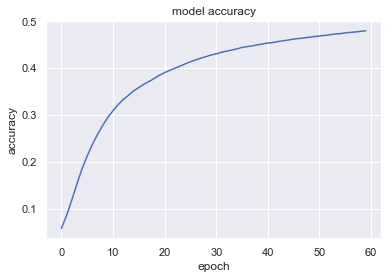

In [126]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

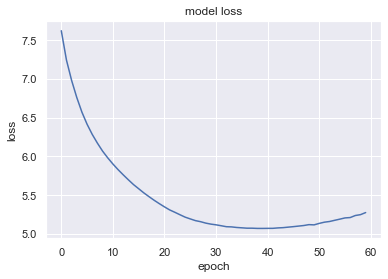

In [127]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [149]:
S1 = """

Создание веб-сервиса краудсорсинговой платформы в связке с моб. приложением. User может 
добавить идею в форму на сайте или через моб. приложение. Мобильное приложение представляет
собой локальную соц. сеть, с мессенджером. User регистируеться, получает доступ к проектным
задачам. Реализованна возможность подписки на получение задач различных сфер. 
У задачи есть рейтинг - отображает приоритет. Тег отображает причастность к направлению. 
У каждой задачи будет коэфф. вознаграждения за лучшую идею. Идея пользователя (заполненная форма) 
имеет тег - с участием какой сферы будет реализовываться задача (IT, безопасность,
машиностроение, менеджмент, электроника и др. ). User могут свободно общаться между собой. 
По каждому направлению (IT,..., экономика и др.)  может быть создана беседа, где будет коллективно
обсуждаться задача. У User будет персональный рейтинг, который выставляют эксперты на общем голосовании.
Лучшие будут приглашаться для стажировки и работы, а их идеи реализовываться.

Вид моб. приложения - мессенджер. Система предполагает высокую нагрузку на сервер,
необходимо проработать бизнес-логику всей системы, и под нее создать эффективную 
клиент- серверную архитектуру. У user есть возможность выбора проекта. 
User должен видеть активность своей идеи.
Первоначальную проверку идеи будет провидить ИИ. 
После интеллектуального анализа ИИ, идея предоставляеться экспертам, 
они выставляют оценки по критериям ( возможность реализации, привлекательность, 
иновацционость, эффективность). Формируеться рейтинг идеи. 
Идеи храняться на сервере. 
Для коллективных проектов предусмотрены беседы до (30 чел.), каждый может предложить до 3 идей, 
с помощью голосования отбираеться 3 лучших от каждой беседы.

  Система мгновенного обмена сообщениями - основа мессенджера. 
  На сервере используем связку php+mysql для логики приложения и 
  CppComet  для доставки сообщений (возможность кластеризации в 
  которой каждый сервер кластера может принимать запросы и пересылать 
  их тем серверам кластера которые надо уведомить о событии. Операции 
  вставки данных (insert и set) выполняются асинхронно, это значит что 
  вы не будете ждать пока запрос будет разослан по всем серверам кластера.). 
      APN/FCM push - сервер используем для отправки push уведомлений. 
      MySQL - для хранения истории сообщений, пользователей, ролей доступа. 
      Сообщения пользователей, запоненая форма идеи конвертируеться в JSON строку. 
      С-Битрикс - для управления мессенджером. (Модульность. Архитектура платформы 
      строится так, что отдельный логически схожий функционал выделяется в независимый модуль. 
      Т.е. ненужное можно отключить, а нужное легко добавить.)
     Мобильный клиент на Java (плюсы ООП: параллельная разработка; гибкость; 
     одни и те же классы можно использовать много раз; код хорошо организован, 
     и его легче поддерживать.).
    Интеллектуальный анализ текста (категоризации называется кластеризацией документов. 
    При этом система ИАТ должна сама определить множество кластеров, по которым могут быть распределены  тексты) 
"""
S1 = prepare_text(S1)

S1 = tokenize.texts_to_matrix([S1])

tags = model.predict(S1)

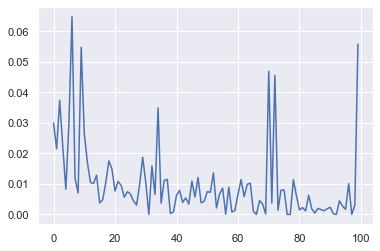

In [150]:
plt.plot(tags.flatten());

In [151]:
def get_n_most_tags(l=LABS,t=tags,n=8):
    t = t.flatten().tolist()
    s = [(l[i],t[i]) for i in range(len(t))]
    s = sorted(s,key=lambda x: x[1])
    return s[-n:]

In [152]:
get_n_most_tags(l=LABS,t=tags,n=8)

[('javascript', 0.030000602826476097),
 ('api', 0.03489489480853081),
 ('google', 0.037411630153656006),
 ('js', 0.04556572064757347),
 ('sql', 0.04692326486110687),
 ('разработка', 0.05475849658250809),
 ('go', 0.05583510175347328),
 ('java', 0.06479950994253159)]

In [153]:
#https://бизнесидея.рф/biznes-plan-fotostudii-s-raschetami
S2 = """Бизнес-план фотостудии: описание проекта Прежде всего, необходимо разобраться: что такое фотостудия? 
Это помещение с большой площадью, которое профессионально оснащено различными интерьерными зонами, что 
позволяет фотографам и их клиентам реализовывать разнообразные тематические фотосессии. В последние несколько 
лет можно наблюдать существенное развитие представленного сегмента бизнеса: люди проявляют все больше интереса 
к процессу, желают обзавестись качественными снимками. Это связывается, в том числе, и с преимуществами 
профессиональных фотосъемок. Профессиональное оборудование и оснащение. Возможность использования качественного 
оборудования, грамотно выставить свет, использовать дополнительные приборы и объекты позволяет получить 
действительно качественные и красивые снимки. Независимость от условий погоды, времени года. Важный плюс 
фотостудии – возможно заходить и сразу начинать съемку, что невозможно при съемках на природе. Кроме того, 
современное оборудование позволяет без проблем воссоздать все необходимые природные эффекты, такие как ветер, 
яркий свет и даже снег. Большое количество декора, интерьерных зон, реквизита и прочего. Все дополнительное 
оборудование – это возможность воплотить нескончаемое количество идей. В условиях фотостудии за один съемочный 
день можно сменить несколько образов. Любая фотостудия, особенно при условиях качественного оснащения ведет 
свою деятельность сразу по двум направлениям, что позволяет существенно увеличить прибыль: это реализация съемок 
с собственным фотографом и сдача зон и оборудования в аренду. В первом случае доход заведения будет больше. 
Однако вторая услуга пользуется большим спросом, поэтому отказываться от нее не следует. Помните о том, что 
если собираетесь оказывать обе обозначенные услуги, об этом потребуется указать в документации при регистрации 
компании. Деятельность любой фотостудии основана на предоставлении конечному потребителю профессиональной 
фотосъемки в интерьерах студии. Главное преимущество – это использование дополнительного оборудования и 
профессионально выставленное освещение. Студийная фотосессия предоставляет клиентам широкие возможности в плане 
творческой работы. Так, за небольшой промежуток времени человек получает большое количество профессиональных 
фотографий в нескольких образах.
Источник: https://xn--90agcbhfc2bzb9j.xn--p1ai/biznes-plan-fotostudii-s-raschetami """

S2 = prepare_text(S2)

S2 = tokenize.texts_to_matrix([S2])

tags = model.predict(S2)

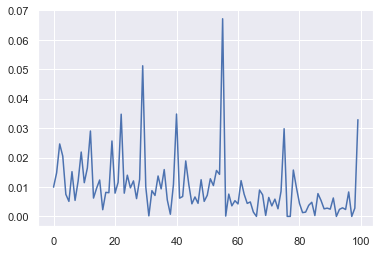

In [154]:
plt.plot(tags.flatten());

In [155]:
get_n_most_tags(l=LABS,t=tags,n=8)

[('социальные сети', 0.025636788457632065),
 ('стартапы', 0.029025474563241005),
 ('технологии', 0.02980279177427292),
 ('go', 0.032880134880542755),
 ('дизайн', 0.03474212810397148),
 ('маркетинг', 0.0347972996532917),
 ('интернет', 0.05120157450437546),
 ('бизнес', 0.06718418002128601)]